<a href="https://colab.research.google.com/github/fun-math/Handwritten-Digit-Classifier/blob/master/Digit_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import random
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# h,b are the height and breadth of image respectively. 
# c is the number of channels (3 for rgb and 1 for gray scale)
# k is the number of classes 
h=28  
b=28
c=1
k=10

# Initial Data Processing

In [ ]:
#Drive location to images
#%cd '/content/drive/My Drive/'

In [ ]:
'''Generate all data in 6 variables in channels last format
train_X : (train_m,h,b,c)
train_y : (train_m,k)
valid_X : (valid_m,h,b,c)
valid_y : (valid_m,k)
X_test  : (test_m,h,b,c)
y_test  : (test_m,k) 
'''

digit_data=tf.keras.datasets.mnist

#(X_train,y_train),(X_test,y_test)=digit_data.load_data()
(data,labels),(X_test,y_test)=digit_data.load_data()
X_test=X_test.reshape(10000,h,b,1)
data=data.reshape(60000,h,b,1)
train_X=data[:50000]
train_y=labels[:50000]
valid_X=data[50000:]
valid_y=labels[50000:]

In [ ]:
train_m=len(train_y)
valid_m=len(valid_y)

In [ ]:
train_y=train_y.reshape(len(train_y),1)
valid_y=valid_y.reshape(len(valid_y),1)

In [ ]:
y_test=y_test.reshape(10000,1)

# Data Augmentation

In [ ]:
train_data_gen=ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    rotation_range=5,                                                
    #zoom_range=[None,None],
    #horizontal_flip=None,
    #vertical_flip=None,                       
)

valid_data_gen=ImageDataGenerator(
    height_shift_range=0.1,
    width_shift_range=0.1,
    #rotation_range=None,                                                
    #zoom_range=[None,None],
    #horizontal_flip=None,
    #vertical_flip=None,                       
)

In [ ]:
factor_train=20
factor_valid=20

m_train=train_m*factor_train
m_valid=valid_m*factor_valid

X_train=np.zeros([m_train,h,b,c])                                
y_train=np.zeros([m_train,1])
   
for i in range(factor_train):                                                    
  it=train_data_gen.flow(train_X,train_y,batch_size=train_m)                        
  temp=next(it)
  X_train[i*train_m:(i+1)*train_m,:,:,:]=temp[0]                                 
  y_train[i*train_m:(i+1)*train_m,:]=temp[1]  


X_valid=np.zeros([m_valid,h,b,c])                                
y_valid=np.zeros([m_valid,1])
for i in range(factor_valid):                                                    
  it=valid_data_gen.flow(valid_X,valid_y,batch_size=valid_m)                        
  temp=next(it)
  X_valid[i*valid_m:(i+1)*valid_m,:,:,:]=temp[0]                                 
  y_valid[i*valid_m:(i+1)*valid_m,:]=temp[1]

In [ ]:
pos=np.arange(len(y_train))
np.random.shuffle(pos)          
X_train=X_train[pos]
y_train=y_train[pos]

pos=np.arange(len(y_valid))
np.random.shuffle(pos)          
X_valid=X_valid[pos]
y_valid=y_valid[pos]

pos=np.arange(len(y_test))
np.random.shuffle(pos)          
X_test=X_test[pos]
y_test=y_test[pos]

In [ ]:
%cd '/content/drive/My Drive/Digit_Classifier'

np.save('X_train',X_train)
np.save('y_train',y_train)
np.save('X_valid',X_valid)
np.save('y_valid',y_valid)
np.save('X_test',X_test)
np.save('y_test',y_test)

/content/drive/My Drive/Digit_Classifier


# Load processed data

In [ ]:
%cd '/content/drive/My Drive/Digit_Classifier'

X_train=np.load('X_train.npy')
y_train=np.load('y_train.npy')
X_valid=np.load('X_valid.npy')
y_valid=np.load('y_valid.npy')
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

/content/drive/My Drive/Digit_Classifier


# Quick peek into some examples

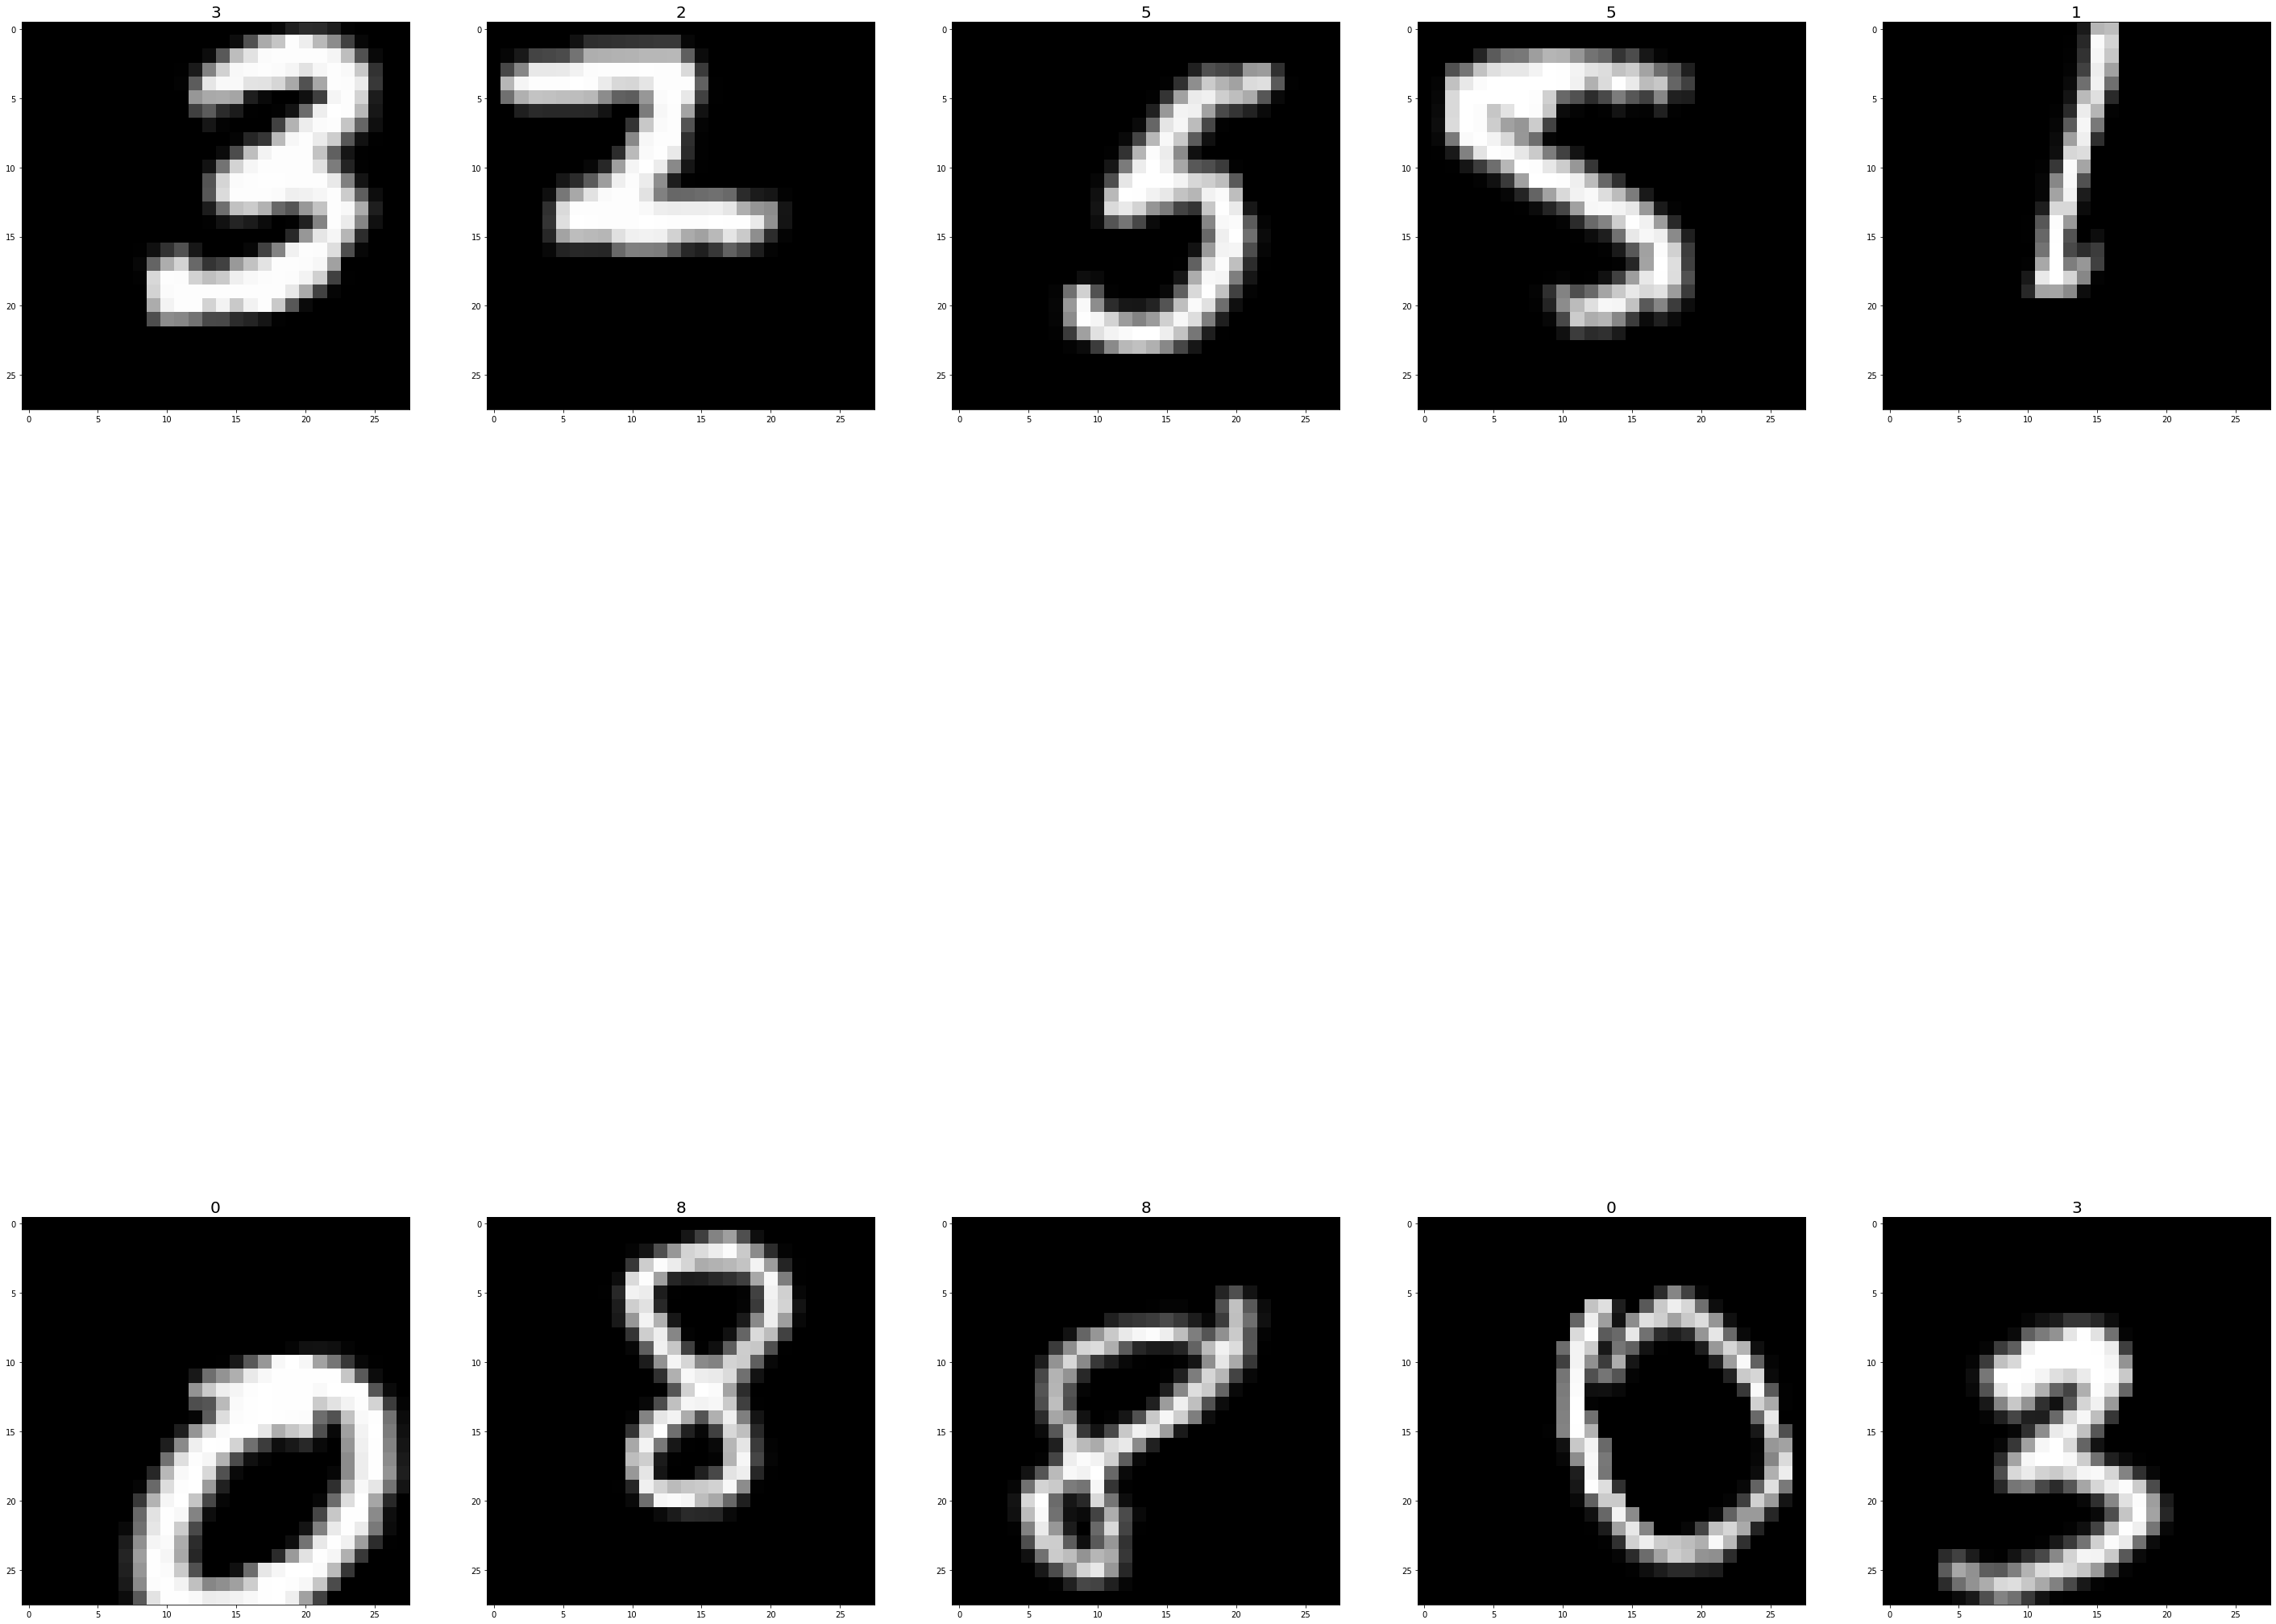

In [ ]:
startind=2000

fig=plt.figure(figsize=(50,50))   
for i in range(10):
  sub=fig.add_subplot(2,5,i+1)
  img=X_train[i+startind].copy()
  img=img.reshape((h,b))                    #Use if image is gray
  #sub.imshow(cv2.cvtColor(img.astype(np.uint8),cv2.COLOR_BGR2RGB))  #Use if image is RGB
  sub.imshow(img.astype(np.uint8),cmap='gray')
  plt.title(int(y_train[i+startind]),fontsize=20)        
plt.show()

# Building and training the model

In [ ]:
X_train=X_train/255.0
X_valid=X_valid/255.0
X_test=X_test/255.0

In [ ]:
print(X_train.shape,X_valid.shape,X_test.shape)

(500000, 28, 28, 1) (100000, 28, 28, 1) (10000, 28, 28, 1)


## Plane sequential model

In [ ]:
inputs=tf.keras.Input(shape=(h,b,c))

x=Conv2D(32,3,1,padding='same',activation='relu')(inputs)

x=Conv2D(64,3,1,padding='same',activation='relu')(x)
x=Conv2D(64,3,1,padding='same',activation='relu')(x)
x=Conv2D(64,3,1,padding='same',activation='relu')(x)
x=Conv2D(64,3,1,padding='same',activation='relu')(x)
x=BatchNormalization()(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(64,3,1,padding='same',activation='relu')(x)
x=Conv2D(64,3,1,padding='same',activation='relu')(x)
x=Conv2D(64,3,1,padding='same',activation='relu')(x)
x=Conv2D(64,3,1,padding='same',activation='relu')(x)
x=BatchNormalization()(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(128,3,1,padding='same',activation='relu')(x)
x=Conv2D(128,3,1,padding='same',activation='relu')(x)
x=Conv2D(128,3,1,padding='same',activation='relu')(x)
x=Conv2D(128,3,1,padding='same',activation='relu')(x)
x=BatchNormalization()(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Flatten()(x)
output=Dense(k,activation='softmax')(x)

model=tf.keras.Model(inputs,output,name='Digit_Classifier')

model.compile(optimizer='adagrad',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

In [ ]:
epochs=40
BATCH_SIZE=512

history=model_leaky.fit(X_train,
                  y_train,
                  batch_size=BATCH_SIZE,
                  epochs=epochs,
                  validation_data=(X_valid,y_valid)
)

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs_range=range(epochs)
plt.plot(epochs_range, acc, label='Training Accuracy',color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color='green')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
predictions=model.predict(X_valid).astype(float)
tf.math.confusion_matrix(y_valid.reshape(len(y_valid),),np.argmax(predictions,axis=1))

# Test the model

In [ ]:
model.evaluate(255.0*X_test,y_test)

In [ ]:
predictions=model.predict(X_test).astype(float)
tf.math.confusion_matrix(y_test.reshape(len(y_test),),np.argmax(predictions,axis=1))

# Save the model

In [ ]:
model.save("Digit_Classifier.h5")      #Example "model{name}_{accuracy}.h5"

#Load Trained Model

In [ ]:
%cd '/content/drive/My Drive/Digit_Classifier'

model=tf.keras.models.load_model('Digit_Classifier_9931.h5')

/content/drive/My Drive/Digit_Classifier


In [ ]:
import pandas as pd

In [ ]:
test_data=np.array(pd.read_csv('test.csv'))

In [ ]:
test=test_data.reshape((len(test_data),28,28,1))
test=test/255.0

In [ ]:
predictions=model.predict(test)
submit=np.argmax(predictions,axis=1)

In [ ]:
submission=pd.DataFrame({'ImageId':np.arange(len(test_data))+1,'Label':submit})
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [ ]:
submission.to_csv("submission_6.csv",index=False)